In [1]:
#----------------------------------------------------------------------
# Importing all libraries needed
#----------------------------------------------------------------------

from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)

import string
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt

from librosa.filters import mel
from collections import Counter
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, MaxPooling2D
from tensorflow.keras.regularizers import l2
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


In [2]:
#----------------------------------------------------------------------
# script to print execution time of each cell
#----------------------------------------------------------------------
%%capture

!pip install ipython-autotime
!pip install python-Levenshtein

%load_ext autotime

time: 254 µs


In [3]:
#----------------------------------------------------------------------
# Script to mount Google Drive
#----------------------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 18.6 s


In [9]:
#----------------------------------------------------------------------
# Setting default Location and no of frames
#----------------------------------------------------------------------

default = '/content/drive/MyDrive/All_Data/'

folder = 'data_splits/Splitted_Data(5)/'
test_folder = 'test_task2/'

num_frames = 201

time: 1.95 ms


In [5]:
#----------------------------------------------------------------------
# Function to read Training files name and corresponding labels
#----------------------------------------------------------------------
def read_csv(filename):
    id_label = {}
    with open(filename,'r') as fid:
        for line in fid:
            tokens = line.strip().split(',')
            id_label[tokens[0]] = tokens[1]
    return id_label

time: 2.32 ms


In [6]:
#----------------------------------------------------------------------
# Making the mel transform matrix
#----------------------------------------------------------------------
n_mels = 513
n_fft = 1024
sr = 44100
mel = mel(sr = sr, n_fft = n_fft, n_mels = n_mels)
mel.shape

/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


(513, 513)

time: 19.5 ms


**Training Section**

In [ ]:
#----------------------------------------------------------------------
# Splitting the training data keeping the souces separated
#----------------------------------------------------------------------
data = read_csv(default + 'labels_train.csv')
data_set = pd.read_csv(default + 'labels_train.csv')
data_set = data_set.sample(frac=1).reset_index(drop=True)
X = data_set['slice_file_name']
Y = data_set['class']
Train={}
Val={}
is_Train= {}
X_Train = []
Y_Train = []
X_Val = []
Y_Val = []
for i in range(len(X)):
    temp_X = X[i]
    j = 0

    while (j<len(temp_X) and temp_X[j]!='-'):
        j+=1
    fs_id = temp_X[0:j]
    temp_label = data[temp_X]
    if (fs_id in Train):
        X_Train.append(temp_X)
        Y_Train.append(temp_label)
    elif (fs_id in Val):
        X_Val.append(temp_X)
        Y_Val.append(temp_label)
    elif (temp_label in is_Train):
        if (is_Train[temp_label]<2):
            X_Train.append(temp_X)
            Y_Train.append(temp_label)
            Train[fs_id] = 1
            is_Train[temp_label]+=1

        elif (len(X_Train)<(4.5)*len(X_Val)):
            X_Train.append(temp_X)
            Y_Train.append(temp_label)
            Train[fs_id] = 1
        else:
            X_Val.append(temp_X)
            Val[fs_id] = 1
            Y_Val.append(temp_label)
    else:
        X_Train.append(temp_X)
        Y_Train.append(temp_label)
        Train[fs_id] = 1
        is_Train[temp_label]=1
# print(len(X_Train))
# print(len(X_Val))
# print(len(Y_Train))
# print(len(Y_Val))

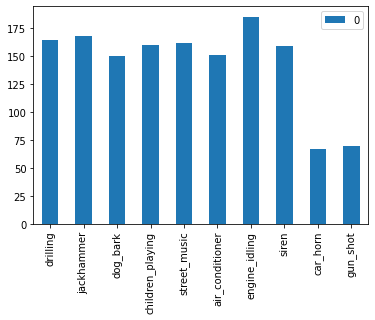

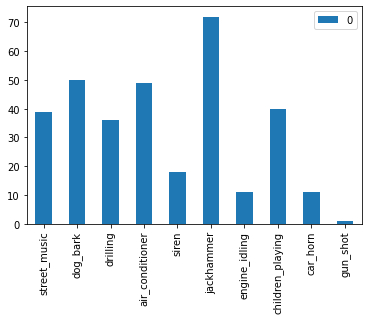

time: 398 ms


In [ ]:
#----------------------------------------------------------------------
# Plotting the Bar plots to see if the split is good enough
#----------------------------------------------------------------------

count1 = Counter(Ytrain)
df1 = pd.DataFrame.from_dict(count1, orient ='index')
df1.plot(kind='bar')

count2 = Counter(Yval)
df2 = pd.DataFrame.from_dict(count2, orient ='index')
df2.plot(kind='bar')

In [ ]:
#----------------------------------------------------------------------
# Converting the splitted data to dictionary format
#----------------------------------------------------------------------
data_train={}
data_val={}
for i in range(len(Xtrain)):
  data_train[Xtrain[i]]=Ytrain[i]
for i in range(len(Xval)):
  data_val[Xval[i]]=Yval[i]

time: 3.33 ms


In [ ]:
#----------------------------------------------------------------------
# Saving the Spliited Data in Dictionary Format
#----------------------------------------------------------------------
field_names= ['slice_file_name', 'label']

with open(default + folder + 'data_train.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    for key, value in data_train.items():
       writer.writerow([key, value])

with open(default + folder + 'data_val.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    for key, value in data_val.items():
       writer.writerow([key, value])

time: 18.6 ms


In [ ]:
#----------------------------------------------------------------------
# Loading the saved splitted data in dictinoary format
#----------------------------------------------------------------------

with open(default + folder + 'data_train.csv') as csv_file:
    reader = csv.reader(csv_file)
    data_train = dict(reader)

with open(default + folder + 'data_val.csv') as csv_file:
    reader = csv.reader(csv_file)
    data_val = dict(reader)

time: 15 ms


In [ ]:
#----------------------------------------------------------------------
# Organizing the training data and reshaping for further use
#----------------------------------------------------------------------

flag=1

for _ in data_train:
        
    if(_ == 'slice_file_name'):
        continue
    if (_[-3:]=='wav'):
        a = _[0:-4] + '.npy'
    else:
        a = _ + '.npy'
    
    temp_data_train = np.transpose(mel.dot(np.load(default + 'Training_data_1ch/' + a)))
    
    length = len(temp_data_train)
    num_pad = (num_frames - (length)%num_frames)%num_frames
    temp_data_train = np.pad(temp_data_train, [(0,num_pad),(0,0)])
    length = len(temp_data_train)
    
    if (flag):
        X_train = np.reshape(temp_data_train, [length//num_frames, num_frames, temp_data_train.shape[1]])
        Y_train = np.vstack([data_train[_]]*(length//num_frames))
        train_labels = np.array([[length//num_frames, data_train[_]]])
    else:
        X_train = np.append(X_train, np.reshape(temp_data_train, [length//num_frames, num_frames, temp_data_train.shape[1]]), axis=0)
        Y_train = np.append(Y_train, np.vstack([data_train[_]]*(length//num_frames)), axis=0)
        train_labels = np.append(train_labels, np.array([[length//num_frames, data_train[_]]]), axis=0)
    flag=0

time: 8min 5s


In [ ]:
#----------------------------------------------------------------------
# Saving the Training Data
#----------------------------------------------------------------------

print(X_train.shape)
print(Y_train.shape)
print(train_labels)

np.save(default + folder + 'melTrain(' + str(num_frames) +')/X_train', X_train)
np.save(default + folder + 'melTrain(' + str(num_frames) +')/Y_train', Y_train)
np.save(default + folder + 'melTrain(' + str(num_frames) +')/train_labels', train_labels)

(2716, 201, 513)
(2716, 1)
[['2' 'siren']
 ['2' 'siren']
 ['2' 'engine_idling']
 ...
 ['2' 'siren']
 ['2' 'children_playing']
 ['2' 'children_playing']]
time: 41.4 s


In [ ]:
#----------------------------------------------------------------------
# Loading the Training Data
#----------------------------------------------------------------------
X_train = np.load(default + folder + 'melTrain(' + str(num_frames) +')/'+'X_train.npy')
Y_train = np.load(default + folder + 'melTrain(' + str(num_frames) +')/'+'Y_train.npy')
train_labels = np.load(default + folder + 'melTrain(' + str(num_frames) +')/'+'train_labels.npy')

time: 1min 4s


In [ ]:
#----------------------------------------------------------------------
# Organizing true labels to one hot vectors
#----------------------------------------------------------------------
encoder = LabelEncoder()
encoder.fit(Y_train.ravel())
np.save(default + 'classes.npy', encoder.classes_)

encoded_Y_train = encoder.transform(Y_train.ravel())
one_hot_Y_train = np_utils.to_categorical(encoded_Y_train)

labels = np.unique(encoded_Y_train)
n_feat = X_train.shape[2]

train_labels[:,1] = encoder.transform(train_labels[:,1])
train_labels = train_labels.astype('int')

time: 198 ms


In [ ]:
#----------------------------------------------------------------------
# Organizing the validation data and reshaping for further use
#----------------------------------------------------------------------

flag=1

for _ in data_val:
        
    if(_ == 'slice_file_name'):
        continue
    if (_[-3:]=='wav'):
        a = _[0:-4] + '.npy'
    else:
        a = _ + '.npy'
    
    temp_data_val = np.transpose(mel.dot(np.load(default + 'Training_data_1ch/' + a)))
    
    length = len(temp_data_val)
    num_pad = (num_frames - (length)%num_frames)%num_frames
    temp_data_val = np.pad(temp_data_val, [(0,num_pad),(0,0)])
    length = len(temp_data_val)
    
    if (flag):
        X_val = np.reshape(temp_data_val, [length//num_frames, num_frames, temp_data_val.shape[1]])
        Y_val = np.vstack([data_val[_]]*(length//num_frames))
        val_labels = np.array([[length//num_frames, data_val[_]]])
    else:
        X_val = np.append(X_val, np.reshape(temp_data_val, [length//num_frames, num_frames, temp_data_val.shape[1]]), axis=0)
        Y_val = np.append(Y_val, np.vstack([data_val[_]]*(length//num_frames)), axis=0)
        val_labels = np.append(val_labels, np.array([[length//num_frames, data_val[_]]]), axis=0)
    flag=0

time: 40.1 s


In [ ]:
#----------------------------------------------------------------------
# Saving the Validation data
#----------------------------------------------------------------------
print(X_val.shape)
print(Y_val.shape)
print(val_labels.shape)

np.save(default + folder + 'melValidate(' + str(num_frames) +')/X_val', X_val)
np.save(default + folder + 'melValidate(' + str(num_frames) +')/Y_val', Y_val)
np.save(default + folder + 'melValidate(' + str(num_frames) +')/val_labels', val_labels)

(600, 201, 513)
(600, 1)
(326, 2)
time: 8.96 s


In [ ]:
#----------------------------------------------------------------------
# Loading the Validation data
#----------------------------------------------------------------------

X_val = np.load(default + folder + 'melValidate(' + str(num_frames) +')/'+'X_val.npy')
Y_val = np.load(default + folder + 'melValidate(' + str(num_frames) +')/'+'Y_val.npy')
val_labels = np.load(default + folder + 'melValidate(' + str(num_frames) +')/'+'val_labels.npy')

time: 460 ms


In [ ]:
#----------------------------------------------------------------------
# Organizing true labels to one hot vectors of validation data
#----------------------------------------------------------------------
encoded_Y_val = encoder.transform(Y_val.ravel())
one_hot_Y_val = np_utils.to_categorical(encoded_Y_val)

val_labels[:,1] = encoder.transform(val_labels[:,1])
val_labels = val_labels.astype('int')

time: 3.79 ms


**CNN**

In [ ]:
#----------------------------------------------------------------------
# Reshaping the Data for cnn model
#----------------------------------------------------------------------
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))
input_dim = (num_frames, n_feat, 1)
output_dim = one_hot_Y_train.shape[1]


#----------------------------------------------------------------------
# Defining the cnn model
#----------------------------------------------------------------------
def cnn_model():

    model = Sequential()

    model.add(Conv2D(32,kernel_size=(3,8),strides=(1,1),padding="Same",input_shape=input_dim, activation = 'relu',kernel_regularizer = l2(0.001)))
    model.add(Conv2D(32,kernel_size=(3,5),strides=(1,1),padding="same", kernel_regularizer = l2(0.001)))
    model.add(MaxPooling2D(pool_size = (4,3), strides = (4,3)))
    

    model.add(Conv2D(64,kernel_size=(3,1),strides=(1,1),padding="Same",kernel_regularizer = l2(0.001)))
    model.add(Conv2D(64,kernel_size=(3,1),strides=(1,1),padding="same",kernel_regularizer = l2(0.001)))
    model.add(MaxPooling2D(pool_size = (4,1), strides = (4,1)))

    model.add(Conv2D(128,kernel_size=(1,5),strides=(1,1),padding="Same",kernel_regularizer = l2(0.001)))
    model.add(Conv2D(128,kernel_size=(1,5),strides=(1,1),padding="same",kernel_regularizer = l2(0.001)))
    model.add(MaxPooling2D(pool_size = (1,3), strides = (1,3)))

    model.add(Flatten())
    model.add(Dense(256,activation="relu"))
    model.add(Dropout(0.7))

    model.add(Dense(64,activation="relu"))
    model.add(Dropout(0.3))

    model.add(Dense(output_dim,activation="softmax"))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    return model


#----------------------------------------------------------------------
# Calculating the model
#----------------------------------------------------------------------
estimator = cnn_model()
history = estimator.fit(X_train, one_hot_Y_train, validation_data = (X_val, one_hot_Y_val), epochs = 10, batch_size = 64)

Epoch 1/10
43/43 [==============================] - 17s 385ms/step - loss: 3.6646 - accuracy: 0.1550 - val_loss: 2.5230 - val_accuracy: 0.2367
Epoch 2/10
43/43 [==============================] - 16s 382ms/step - loss: 2.4438 - accuracy: 0.2493 - val_loss: 2.5559 - val_accuracy: 0.2800
Epoch 3/10
43/43 [==============================] - 17s 385ms/step - loss: 2.2686 - accuracy: 0.3303 - val_loss: 2.3361 - val_accuracy: 0.2867
Epoch 4/10
43/43 [==============================] - 17s 388ms/step - loss: 2.0163 - accuracy: 0.4227 - val_loss: 2.1392 - val_accuracy: 0.2883
Epoch 5/10
43/43 [==============================] - 17s 391ms/step - loss: 1.8051 - accuracy: 0.4768 - val_loss: 2.2243 - val_accuracy: 0.4033
Epoch 6/10
43/43 [==============================] - 17s 395ms/step - loss: 1.6356 - accuracy: 0.5449 - val_loss: 2.0668 - val_accuracy: 0.4767
Epoch 7/10
43/43 [==============================] - 17s 395ms/step - loss: 1.4433 - accuracy: 0.6270 - val_loss: 2.3339 - val_accuracy: 0.4533

**Check How Model Worked**

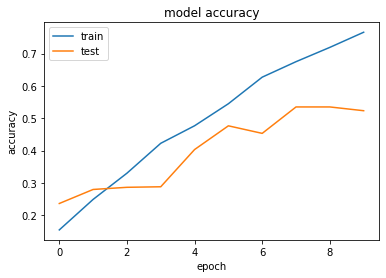

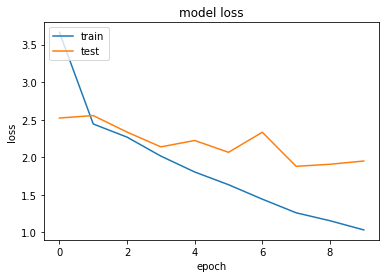

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 201, 513, 32)      800       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 201, 513, 32)      15392     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 50, 171, 32)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 50, 171, 64)       6208      
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 50, 171, 64)       12352     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 12, 171, 64)       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 12, 171, 128)     

In [ ]:
#----------------------------------------------------------------------
# Plotting the history of the model and printing the model summary
#----------------------------------------------------------------------

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(default + folder + '2Plots2/Accuracy.png', dpi=800)
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(default + folder + '2Plots2/Loss.png', dpi=800)
plt.show()

estimator.summary()

In [ ]:
#----------------------------------------------------------------------
# Predicting labels of Validation Set
#----------------------------------------------------------------------

predictions = estimator.predict_proba(X_val)

i=0
Y_true = val_labels[:,1]
Y_pred = np.zeros(val_labels[:,0].shape)
for j in range(len(val_labels)):
    index = val_labels[j][0]+i
    A = predictions[i:index, :]
    Y_pred[j]=(np.argmax(np.sum(A, axis=0)))
    i=index

time: 1.25 s


In [ ]:
#----------------------------------------------------------------------
# Outputting quantitaive metrics
#----------------------------------------------------------------------

CM = np.zeros((output_dim,output_dim))
for i in range(len(Y_pred)):
    CM[Y_true[i]][np.int(Y_pred[i])] += 1
print('Audio labels Result -> ')
print('Confusion Matrix ->')
print(CM)
print('Accuracy Score ->', accuracy_score(Y_true, Y_pred))
print('\n')

Audio labels Result -> 
Confusion Matrix ->
[[ 7.  0.  5.  0.  1.  3.  0. 11.  0.  0.]
 [ 0.  6.  0.  1.  0.  0.  0.  0.  0.  1.]
 [ 4.  0. 18.  4.  0.  0.  0.  0.  0.  7.]
 [ 2.  0.  6. 38.  0.  3.  2.  1.  2.  1.]
 [ 0.  0.  0.  1. 30.  1.  0.  3.  2.  1.]
 [19.  0.  0.  0.  0.  8.  0.  0.  0.  6.]
 [ 0.  0.  1.  0.  1.  0. 17.  0.  1.  0.]
 [ 7.  0.  2.  0. 17.  0.  0. 14.  0.  2.]
 [ 0.  0.  7.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  7.  1.  7.  1.  0.  2.  0. 44.]]
Accuracy Score -> 0.558282208588957


time: 9.15 ms


In [ ]:
#----------------------------------------------------------------------
# Saving the trained model
#----------------------------------------------------------------------
estimator.save(default + folder + 'melModel(' + str(num_frames) + ')')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/All_Data/data_splits/Splitted_Data(5)/melModel(201)/assets
time: 2.27 s


**Testing Section**

In [20]:
#----------------------------------------------------------------------
# Loading data of test_task2 and declaring some parameters
#----------------------------------------------------------------------
data_test=[]
for i in range(1,31):
    if (i<10):
        a = 'a00' + str(i)
    else:
        a = 'a0' + str(i)
    data_test.append(a)

hop_size = 25
w_s = 10
min = 5

time: 2.66 ms


In [21]:
#----------------------------------------------------------------------
# Organizing data of test task 2 to test the model
#----------------------------------------------------------------------

flag=1

for _ in data_test:
    if(_ == 'slice_file_name'):
        continue
    if (_[-3:]=='wav'):
        a = _[0:-4] + '.npy'
    else:
      a = _ + '.npy'

    temp_data_test = np.transpose(mel.dot(np.load(default + test_folder + 'feats/' + a)))
    
    length = len(temp_data_test)
    if (length<num_frames):
        num_pad = (num_frames - length%num_frames)%num_frames
    else:
        num_pad = (hop_size - (length-num_frames)%hop_size)%hop_size
    
    temp_data_test = np.pad(temp_data_test, [(0,num_pad),(0,0)])
    length = len(temp_data_test)

    temp_X = np.vstack(np.array([temp_data_test[i:i+num_frames]]) for i in range(0, (length-num_frames) + 1, hop_size))

    if (flag):
        X_test = temp_X
        # Y_test = np.vstack([data_test[_]]*(length//num_frames))
        test_labels = np.array([[(length-num_frames)//hop_size + 1]])
    else:
        X_test = np.append(X_test, temp_X, axis=0)
        # Y_test = np.append(Y_test, np.vstack([data_test[_]]*(length//num_frames)), axis=0)
        test_labels = np.append(test_labels, np.array([[(length-num_frames)//hop_size + 1]]), axis=0)
    flag=0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


time: 4.59 s


In [22]:
#----------------------------------------------------------------------
# Loading the Model and the label encoder
#----------------------------------------------------------------------
model = models.load_model(default + folder + 'melModel(' + str(num_frames) + ')')

encoder = LabelEncoder()
encoder.classes_ = np.load(default + 'classes.npy')

#----------------------------------------------------------------------
# Predicting labels of each extracted frame
#----------------------------------------------------------------------

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

predictions = np.argmax(model.predict(X_test), axis=-1)
predictions_one_hot = np_utils.to_categorical(predictions)

time: 3.99 s


In [23]:
#----------------------------------------------------------------------
# Filtering out required prediction
#----------------------------------------------------------------------

Full_Prediction = []

i=0
for j in range(len(test_labels)):
    index = test_labels[j][0]+i
    A = predictions_one_hot[i:index, :]
    temp_list=[]
    last_element=-1
    for t in range(len(A)-w_s):
        B = np.sum(A[t:t+w_s, :], axis=0)
        b = np.argmax(B)
        if (B[b]<min):
            continue
        elif (b==last_element):
            continue
        else :
            temp_list.append(b)
            last_element = b
    Full_Prediction.append(temp_list)
    i=index

for i in range(len(Full_Prediction)):
    Full_Prediction[i]=encoder.inverse_transform(Full_Prediction[i])

time: 33.1 ms


In [24]:
#----------------------------------------------------------------------
# Extracting and saing the labels in the required format
#----------------------------------------------------------------------
output = {}
i=0

for _ in data_test:
    output[_] = '-'.join(Full_Prediction[i])
    i=i+1

with open(default + test_folder + 'est(25).csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    for key, value in output.items():
        writer.writerow([key, value])

time: 11.2 ms
